<a href="https://colab.research.google.com/github/ZosoV/mri_classification/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for MRI Classification

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/neuromatch/
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/neuromatch
Brain-Tumor-Classification-DataSet  experiment_01  experiment_03
checkpoint			    experiment_02  results


In [ ]:
!ls

Brain-Tumor-Classification-DataSet  experiment_01  experiment_03
checkpoint			    experiment_02  results


In [ ]:
!pip install torchinfo

# Setup

In [ ]:
# imports
import os
import gc
import csv
import glob
import torch
import multiprocessing

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18, vgg16, vgg19, vgg19_bn
from torchinfo import summary
import PIL

In [ ]:
!nvidia-smi

Thu Aug 19 15:03:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##  Set random seed

 Executing `set_seed(seed=seed)` you are setting the seed


In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

##  Set device (GPU or CPU)


In [ ]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

### Random seeds

If you want to obtain reproducible results, it is a good practice to set seeds for the random number generators of the various libraries

In [ ]:
set_seed(seed=2021)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


### Training hyperparameters

Here we set some general training hyperparameters such as the learning rate, batch size, etc. as well as other training options such as including data augmentation (`torchvision_transforms`).

In [ ]:
# Hyper-parameters
use_cuda = torch.cuda.is_available()
batch_size = 128
torchvision_transforms = True  # True/False if you want use torchvision augmentations
SIZE = (224,224)

result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')

---
# Data

## Source dataset

We will train the model using Brain Tummor Classification data set from Kaggle, but with small tweaks we can get any other data we are interested in.

Note that the data set is normalised by substracted the mean and dividing by the standard deviation (pre-computed) of the training set. Also, if `torchvision_transforms` is `True`, data augmentation will be applied during training.

 Download and prepare Data


In [ ]:
# Download the dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

fatal: destination path 'Brain-Tumor-Classification-DataSet' already exists and is not an empty directory.


In [ ]:
print('==> Preparing data..')
def percentageSplit(full_dataset, percent = 0.0):
  set1_size = int(percent * len(full_dataset))
  set2_size = len(full_dataset) - set1_size
  final_dataset, _ = torch.utils.data.random_split(full_dataset, [set1_size, set2_size])
  return final_dataset

# ImageNet normalizing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# torchvision transforms
transform_train = transforms.Compose([])
if torchvision_transforms:
  # transform_train.transforms.append(transforms.RandomCrop(SIZE, padding=10))
  transform_train.transforms.append(transforms.RandomHorizontalFlip(p=0.30))
  transform_train.transforms.append(transforms.RandomRotation(degrees=30))
  transform_train.transforms.append(transforms.RandomAffine(degrees=(0, 0), translate=(0.1, 0)))
  # Noise -> in dependance of the image
  transform_train.transforms.append(transforms.RandomAutocontrast(p = 0.3))
  # transform_train.transforms.append(transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)))
  #transform_train.transforms.append(transforms.AutoAugment())

  # contrast #blur noise

transform_train.transforms.append(transforms.Resize(SIZE))
transform_train.transforms.append(transforms.ToTensor())
transform_train.transforms.append(transforms.Normalize(mean, std))

transform_test = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.ImageFolder(
  root= 'Brain-Tumor-Classification-DataSet/Training', transform=transform_train)

testset = torchvision.datasets.ImageFolder(
  root='Brain-Tumor-Classification-DataSet/Testing', transform=transform_test)

==> Preparing data..


In [ ]:
# print the size of dataset
print("Train images: ", len(trainset))
print("Test images: ", len(testset))
classes_names = trainset.classes
print(classes_names)

Train images:  2870
Test images:  394
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


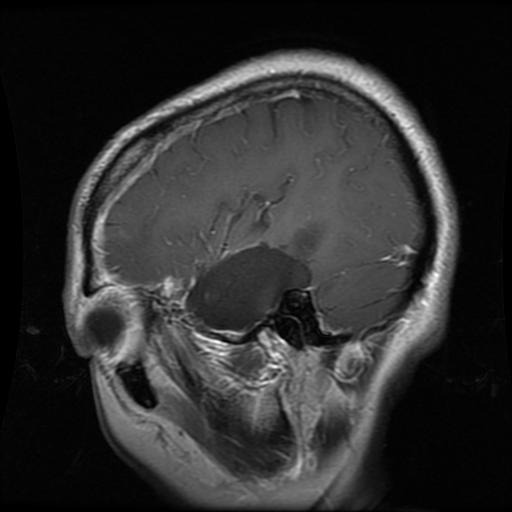

In [ ]:
exp_img = PIL.Image.open("Brain-Tumor-Classification-DataSet/Training/glioma_tumor/gg (100).jpg")
exp_img

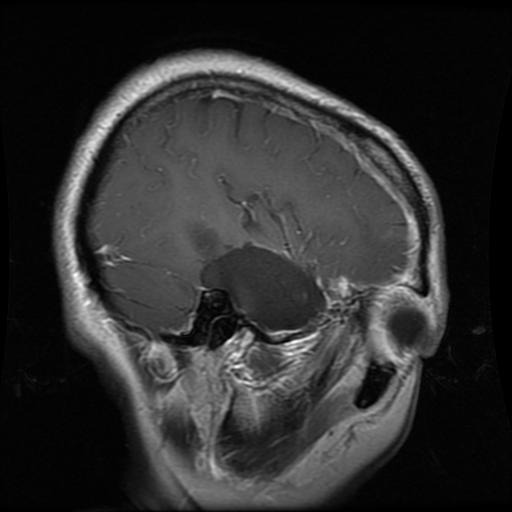

In [ ]:
transforms.RandomHorizontalFlip(p=1)(exp_img)

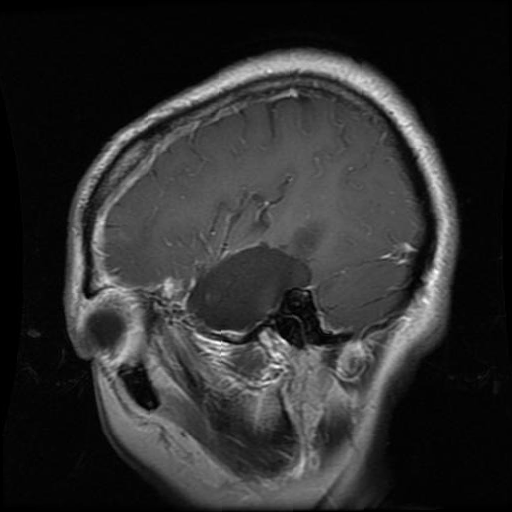

In [ ]:
transforms.RandomRotation(degrees=30)(exp_img)

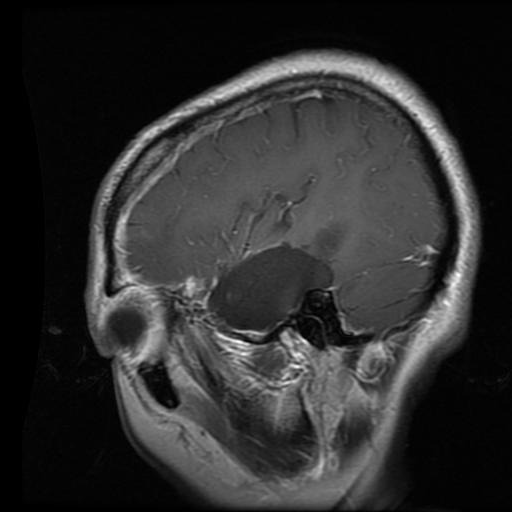

In [ ]:
transforms.RandomAffine(degrees=(0, 0), translate=(0.1, 0))(exp_img)

## Data loaders

A dataloader is an optimized data iterator that provides functionality for efficient shuffling, transformation and batching of the data.

###  Dataloader


In [ ]:
##@title Dataloader
num_workers = multiprocessing.cpu_count()

print(f'----> number of workers: {num_workers}')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

----> number of workers: 2


# Displaying Data

In [ ]:
# @title Plotting functions

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

def imshow(img):
  plt.figure(figsize=[20, 20])
  #unnormalize
  #img = img * torch.tensor(std).unsqueeze(dim=-1).unsqueeze(dim=-1)
  #img = img + torch.tensor(mean).unsqueeze(dim=-1).unsqueeze(dim=-1)
  img = UnNormalize(mean,std)(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()

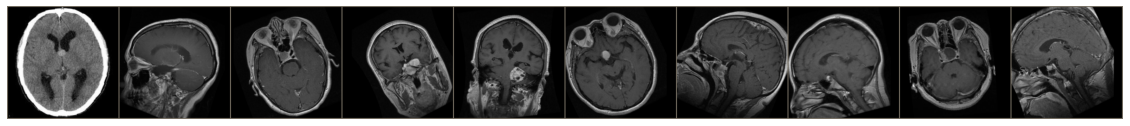

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images[:10], nrow = 10))

### Train the target model

In [ ]:
#@title Util functions

def print_lr(optimizer):
  tmp_list = []
  for param_group in optimizer.param_groups:
    tmp_list.append(param_group['lr'])

  print("lr per group", tmp_list, "mean: ", np.mean(tmp_list))

  return np.mean(tmp_list)

In [ ]:
# Training & Test functions

def train(net, epoch, use_cuda=True):
  print('\nEpoch: %d' % epoch)
  net.train() # set the model in training mode
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets) # Why here is used Variable. Is it needed?
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() # is the code getting the avg loss since the first iteration batch?
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()

    if batch_idx % 500 == 0:
      print("Train ",batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
  return (train_loss/batch_idx, 100.*correct/total)


def test(net, epoch, outModelName, use_cuda=True, save = False):
  global best_acc
  net.eval() # set the model in eval mode
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 200 == 0:
        print("Test ", batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    best_acc = acc
  if save:
    #checkpoint(net, acc, epoch, outModelName)
    torch.save(model, f'./checkpoint/{outModelName}_acc({str(acc.item()).replace(".","-")})_epoch({epoch}).pt')

  return (test_loss/batch_idx, 100.*correct/total)

In [ ]:
best_acc = 0  # best test accuracy

def main(model, max_epochs, outModelName):
  logname = result_folder + f'{outModelName}.csv'

  if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
      logwriter = csv.writer(logfile, delimiter=',')
      logwriter.writerow(['epoch', 'train loss', 'train acc', 'test loss', 'test acc', 'lr'])

  for epoch in range(max_epochs):
    # adjust_learning_rate(optimizer, base_learning_rate = 1e-3, epoch= epoch)
    lr_mean = print_lr(optimizer)
    train_loss, train_acc = train(model, epoch, use_cuda=use_cuda)
    save = True if epoch == max_epochs - 1 else False
    test_loss, test_acc = test(model, epoch, outModelName, use_cuda=use_cuda, save = save)
    with open(logname, 'a') as logfile:
      logwriter = csv.writer(logfile, delimiter=',')
      logwriter.writerow([epoch, train_loss, train_acc.item(), test_loss, test_acc.item(), lr_mean])
    print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc} | lr: {lr_mean}' )

# Experiment: Train the complete model

In [ ]:
class MyVGG19(nn.Module):
    def __init__(self, pretrained_model, max_frozen_layer = None, freeze = False):
        super(MyVGG19, self).__init__()
        self.model = pretrained_model

        # Freeze the model parameters
        if freeze and max_frozen_layer is None:
          # freeze all the convolutional layer
          for param in self.model.parameters():
            param.requires_grad = False
        elif freeze and max_frozen_layer is not None:
          # freeze the convolutional until max_frozen layer
          counter = 0
          for param in self.model.parameters():
            if counter < max_frozen_layer:
              print(f"Freezing layer {counter}")
              param.requires_grad = False
              counter += 1

        self.model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        # Replace the classifier part
        self.model.classifier = nn.Sequential( #move dropout early
            nn.Linear(512, 256, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.6), # a little bigger
            nn.Linear(256, 128, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.6), # a little bigger
            nn.Linear(128, 4, bias = True)
            )
            
    def forward(self, x):
        return self.model(x)

In [ ]:
# pretrained_model = vgg16(pretrained=True)
# pretrained_model = vgg19(pretrained=True)
pretrained_model = vgg19(pretrained=True)

# # pretrained_model = resnet18(pretrained=True)
# # pretrained_model = vgg11(pretrained=True)

model = MyVGG19(pretrained_model=pretrained_model)
model.to(device)
print(model)

# define the loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-4,
    momentum=0.9,
    weight_decay=1e-4,
)

# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=1e-4
# )


MyVGG19(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): 

#### Check number of parameters

We can calculate the number of total parameters and the number of trainable parameters, that is those that will be updated during training. Since we have freezed most of the parameters, the number of training parameters should be much smaller.

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Total Parameters:', total_params, 'Trainable parameters: ', trainable_total_params)

Total Parameters: 20189124 Trainable parameters:  20189124


In [ ]:
main(model, max_epochs = 30, outModelName = "vgg19_complete_additional_exp_004")

lr per group [0.0001] mean:  0.0001

Epoch: 0
Train  0 23 Loss: 1.396 | Acc: 22.656% (29/128)
Test  0 4 Loss: 1.383 | Acc: 2.344% (3/128)
Epoch: 0 | train acc: 26.689895629882812 | test acc: 19.28934097290039 | lr: 0.0001
lr per group [0.0001] mean:  0.0001

Epoch: 1
Train  0 23 Loss: 1.384 | Acc: 23.438% (30/128)
Test  0 4 Loss: 1.381 | Acc: 0.781% (1/128)
Epoch: 1 | train acc: 26.898954391479492 | test acc: 18.781726837158203 | lr: 0.0001
lr per group [0.0001] mean:  0.0001

Epoch: 2
Train  0 23 Loss: 1.391 | Acc: 23.438% (30/128)
Test  0 4 Loss: 1.378 | Acc: 0.781% (1/128)
Epoch: 2 | train acc: 25.609756469726562 | test acc: 18.781726837158203 | lr: 0.0001
lr per group [0.0001] mean:  0.0001

Epoch: 3
Train  0 23 Loss: 1.381 | Acc: 25.000% (32/128)
Test  0 4 Loss: 1.376 | Acc: 0.781% (1/128)
Epoch: 3 | train acc: 27.073171615600586 | test acc: 18.781726837158203 | lr: 0.0001
lr per group [0.0001] mean:  0.0001

Epoch: 4
Train  0 23 Loss: 1.380 | Acc: 28.125% (36/128)
Test  0 4 Loss:

KeyboardInterrupt: ignored

## Freeze layers

In [ ]:
pretrained_model = vgg19_bn(pretrained=True) #TODO: change the network

model = MyVGG19(pretrained_model=pretrained_model, freeze = True) #, max_frozen_layer=24)
model.to(device)
#print(model)

# define the loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-5,
    momentum=0.9,
    weight_decay= 1e-4 # l2 regularization
)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Total Parameters:', total_params, 'Trainable parameters: ', trainable_total_params)

In [ ]:
main(model, max_epochs = 20, outModelName = "vgg19_frozen_exp_03")

lr per group [0.0001] mean:  0.0001

Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train  0 45 Loss: 1.386 | Acc: 26.562% (17/64)
Test  0 7 Loss: 2.310 | Acc: 17.188% (11/64)
Epoch: 0 | train acc: 69.68640899658203 | test acc: 50.76142120361328 | lr: 0.0001
lr per group [0.0001] mean:  0.0001

Epoch: 1
Train  0 45 Loss: 0.589 | Acc: 79.688% (51/64)
Test  0 7 Loss: 2.929 | Acc: 12.500% (8/64)
Epoch: 1 | train acc: 82.40418243408203 | test acc: 57.106597900390625 | lr: 0.0001
lr per group [0.0001] mean:  0.0001

Epoch: 2
Train  0 45 Loss: 0.499 | Acc: 81.250% (52/64)
Test  0 7 Loss: 2.952 | Acc: 10.938% (7/64)
Epoch: 2 | train acc: 85.2961654663086 | test acc: 59.898475646972656 | lr: 0.0001
lr per group [0.0001] mean:  0.0001

Epoch: 3
Train  0 45 Loss: 0.404 | Acc: 84.375% (54/64)
Test  0 7 Loss: 3.233 | Acc: 12.500% (8/64)
Epoch: 3 | train acc: 87.38675689697266 | test acc: 61.67512512207031 | lr: 0.0001
lr per group [0.0001] mean:  0.0001

Epoch: 4
Train  0 45 Loss: 0.266 | Acc: 92.188% (59/64)
Test  0 7 Loss: 2.939 | Acc: 21.875% (14/64)
Epoch: 4 | train acc: 88.4

In [ ]:
!ls gdrive/My

gdrive	sample_data


## Plot results

In [ ]:
#@title Util Functions

def plot_results(results, name):
  train_accuracy = results['train acc'].values
  test_accuracy = results['test acc'].values

  train_loss = results['train loss'].values
  test_loss = results['test loss'].values

  figureName = name +"_accuracy" # change figure name

  plt.style.use('fivethirtyeight')
  fig, (ax1, ax2) = plt.subplots(figsize=(16,8),nrows=1, ncols=2, sharex=True, sharey=False)
  ax1.plot(results['epoch'].values, train_accuracy, label='train', color='r', marker='s', lw=3)
  ax1.plot(results['epoch'].values, test_accuracy, label='test', color='b', marker='o', lw=3)
  ax1.legend()
  ax1.set_ylim([0,100])
  ax1.set(xlabel="Epochs", ylabel="Accuracy Score")
  ax2.plot(results['epoch'].values, train_loss, label='train', color='r', marker='s', lw=3)
  ax2.plot(results['epoch'].values, test_loss, label='test', color='b', marker='o', lw=3)
  ax2.legend()
  ax2.set(xlabel="Epochs", ylabel="CrossEntropy Loss")
  fig.savefig(f'./results/{figureName}.png')
  plt.show()


In [ ]:
!ls results

comparison_best_experiment_01.png
comparison_best_experiment_02.png
comparison_experiment_01.png
comparison_experiment_02.png
MyVGG19_complete_model_5_mri.csv
MyVGG19_frozen_model_bn_1_mri_accuracy.png
MyVGG19_frozen_model_bn_1_mri.csv
MyVGG19_frozen_model_bn_2_mri_accuracy.png
MyVGG19_frozen_model_bn_2_mri.csv
MyVGG19_frozen_model_bn_3_mri_accuracy.png
MyVGG19_frozen_model_bn_3_mri.csv
MyVGG19_frozen_model_bn_4_mri_accuracy.png
MyVGG19_frozen_model_bn_4_mri.csv
MyVGG19_frozen_model_bn_5_mri_accuracy.png
MyVGG19_frozen_model_bn_5_mri.csv
MyVGG19_frozen_model_bn_6_mri.csv
MyVGG19_VGG19_bn_dropout_test_01.csv
MyVGG19_VGG19_bn_test_01.csv
MyVGG19_VGG19_test_01.csv
MyVGG19_VGG19_test_01.png
result.png


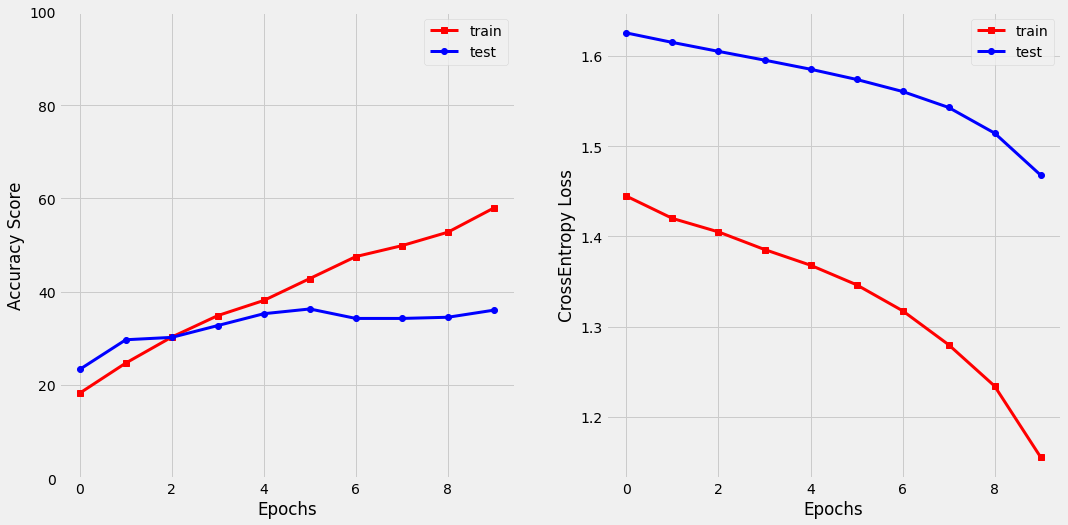

In [ ]:
name = "vgg19_complete_exp_03"
results = pd.read_csv(f'./results/{name}.csv', sep =',')
plot_results(results, name)